In [1]:
# !pip install -e ../..
# !pip install -r ../requirements.txt

In [2]:
import itertools as it
import coba as cb
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
SAMPLES = 10_000
PROCESSES = 30
TIMESTAMP = datetime.now()
print(TIMESTAMP)

2023-07-06 15:10:25.182889


## Evaluating Policies From Logged Data

A common task when working with logged bandit feedback is to estimate how well a new policy would perform in the logged environment.

To perform off policy evaluation there are three common estimators used in the literature:

  1. Inverse Propensity Score (IPS) -- a higher-variance lower-bias estimator
  2. Direct Method (DM) -- a lower-variance higher-bias estimator
  3. Doubly Robust (DR) -- a lower-variance lower-bias estimator
  
We will evaluate all three of these methods against ground truth using 208 simulated datasets.


#### 1. Create our evaluation data

To create our logged data we use a `MisguidedLearner`. This learner will behave very differently from the evaluation policies.

In [4]:
from coba import VowpalRndLearner

envs1 = cb.Environments.cache_dir('.coba_cache').from_template('../templates/class208.json',n_take=SAMPLES,strict=True).chunk()
logs1 = envs1.logged(VowpalRndLearner()).shuffle().ope_rewards([None,'IPS','DM','DR']).cache()

#### 2. Define the experiment

In [5]:
experiment1 = cb.Experiment(logs1, cb.VowpalEpsilonLearner(), cb.OffPolicyEvaluator())

#### 3. Run the experiment

In [6]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment1.run(f'out1_{TIMESTAMP}.log.gz',processes=PROCESSES,quiet=True)

CPU times: user 22.7 s, sys: 3.36 s, total: 26.1 s
Wall time: 22min 5s
{'Learners': 1, 'Environments': 832, 'Interactions': 5760000}


#### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [7]:
result1 = cb.Result.from_file(f'out1_{TIMESTAMP}.log.gz')

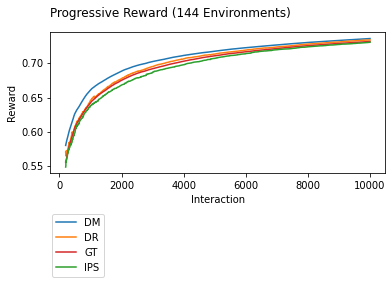

In [8]:
result1.filter_fin(SAMPLES).plot_learners(xlim=(200,None),l='ope_reward',p='openml_task',labels=['DM','DR','IPS','GT'])

In the plot above we can see how each of our reward estimators performed relative to the ground truth (GT). We know the ground truth  due to working with simulated data. In practice, when working with real world data, we won't know this value and will have to use a reward estimator such as DM, DR, or IPS instead.

Based on the plot above it appears that IPS estimates GT most poorly while DM estimates it best. This is not the full story though because what is plotted above is the average over all of our data sets and so it can hide extreme errors. By hidden extremes what we mean is this, imagine two people are trying to estimate the height of a five foot tall person. We will call our two people estimators. The first estimator guesses the person is 3' tall and 7' tall while the second estimator guesses the person is 4'11" and 5'1" tall. Now both of these people were correct on average (i.e., for both estimators their average estimate was 5' which was the ground truth) but one of them we could argue was a better estimator because not only were they right on average but their estimates were also close to the ground truth. This is what we mean by hidden extremes. To look for this we create a contrast plot.

[]

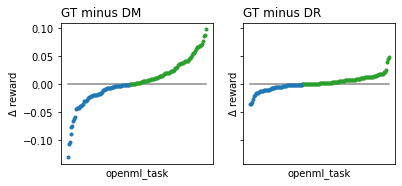

In [9]:
f,ax = plt.subplots(ncols=2,sharey=True)
result1.filter_fin(SAMPLES).plot_contrast('None','DM',x='openml_task',l='ope_reward',p='openml_task',err='sd',ax=ax[0],xticks=False,legend=False,out=None)
result1.filter_fin(SAMPLES).plot_contrast('None','DR',x='openml_task',l='ope_reward',p='openml_task',err='sd',ax=ax[1],xticks=False,legend=False,out=None)
ax[0].set_title('GT minus DM',loc='left')
ax[0].set_xticks([])
ax[1].set_title('GT minus DR',loc='left')
ax[1].set_xticks([])

The plot above shows the difference between the DM and DR estimator relative to GT on all of our datasets. This is the distribution of estimates that are being averaged over in the the first plot. Here we can see that the DR estimator has a very similar pattern to the DM estimator but more tamed extremes. To put it exactly, the DR error range from approximately -0.20 to 0.20 while the DM error ranges from -0.45 to .40. We can show this same result using the variance of our mean.

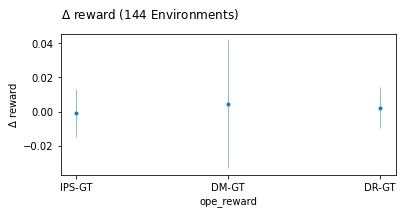

In [10]:
result1.filter_fin(SAMPLES).plot_contrast('None',['IPS','DM','DR'],x='ope_reward',l='ope_reward',p='openml_task',err='sd',boundary=False,legend=False,out=None)
plt.xticks(['IPS-None','DM-None','DR-None'],['IPS-GT','DM-GT','DR-GT'])
plt.show()

The plot above shows a point estimate for difference from ground truth for each of our estimators. That is, each point in this plot is equal to the difference between each estimator and ground truth in the first figure. The blue lines shows standard deviation of the estimates making up each point. We can see that the standard deviation for the DM-GT errors is much larger than the standard deviation for the DR-GT error. We can also see that while IPS is off base its standard deviation is a little smaller than DM. In fact as IPS gets more data it should begin to beat DM both in terms of error standard deviation and the average point estimate. We can actually see this happening if we create one more plot by interactions.

/mnt/user-home/git/coba/coba/experiments/results.py:586: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111) if not isinstance(ax,int) else plt.subplot(ax)


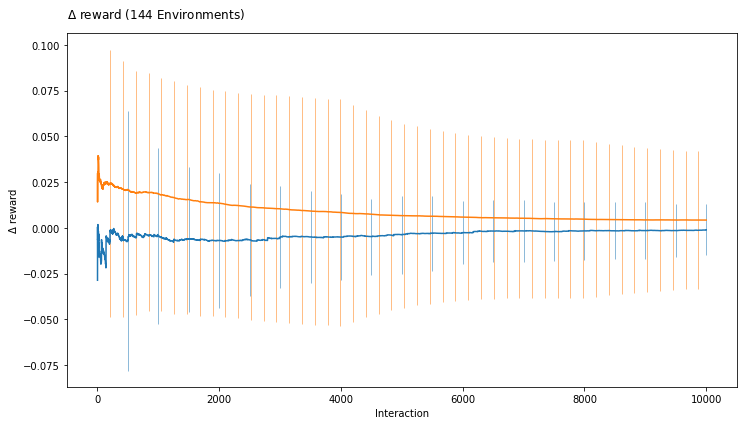

In [11]:
plt.figure(figsize=(12,10))
result1.filter_fin(SAMPLES).plot_contrast('None','DM',x='index',l='ope_reward', p='openml_task',colors=1,err='sd',errevery=210,boundary=False,out=None)
result1.filter_fin(SAMPLES).plot_contrast('None','IPS',x='index',l='ope_reward',p='openml_task',colors=0,err='sd',boundary=False,legend=False,out=None)

The plot above shows the average difference between ground truth and IPS/DM. The orange line is the DM error with standard deviations while the blue line is IPS error. We can see that DM error consistent. It doesn't improve, doesn't get worse. It starts out really good and just kidn of stays there. The IPS estimator on the other hand starts off pretty horribly and gets better and better. It's still not great by the end but this trend would continue. Given another 5,000 examples or so IPS would almost certainly do better than DM. And here's the secret to DR. Doubly robust is a combination of DM and IPS. So, it will start off strong like DM while also getting better and better with more data like IPS. 

---

## Evaluating Exploration From Logged

Our goal is to use logged data to estimate online exploration performance.

To do this we have three options:
  1. Perform on-policy evaluation using a reward estimator
  2. Perform off-policy evaluation using the logged data
  3. Use rejection sampling to make the logged data look like the desired exploration
  
We will evaluate all three options using logged data that we generate from a large set of classification datasets. By conducting this experiment over many datasets we can get a sense of the expected performance for each method independent of any one dataset. We will also intentionally use a misguided logging policy to generate our data to ensure that the logging policy doesn't look anything like the policies we wish to estimate.  

#### 1. Create evaluation data
To create our logged data we use a `MisguidedLearner`. This learner behaves very differently from the policies we want to evaluate.

In [21]:
envs2 = cb.Environments.cache_dir('.coba_cache').from_template('../templates/class208.json',n_take=200_000,strict=True).chunk()
# logs2 = envs2.logged(VowpalRndLearner).ope_rewards("DR").cache()
logs2 = envs2.logged(cb.MisguidedLearner(cb.VowpalEpsilonLearner(),1,-1)).ope_rewards("DR").cache()

#### 2. Define the experiment 

In [22]:
ground_truth  = it.product(envs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
first_option  = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OnPolicyEvaluator()])
second_option = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.OffPolicyEvaluator()])
third_option  = it.product(logs2,[cb.VowpalEpsilonLearner()],[cb.ExplorationEvaluator()])

experiment2 = cb.Experiment(it.chain(ground_truth,first_option,second_option,third_option))

#### 3. Run the experiment

In [23]:
%%time
#WARNING: This can take some time to finish.
#WARNING: To simply see the results look below.
experiment2.run(f'out2_{TIMESTAMP}.log.gz',processes=PROCESSES,quiet=True)

CPU times: user 11min 41s, sys: 2min 18s, total: 14min
Wall time: 3h 6min 36s
{'Learners': 4, 'Environments': 416, 'Interactions': 45660734}


#### 4. Analyze the results

We plot the experimental results to see which one of our three options best utilized the logged data to predict online performance.

In [24]:
result2 = cb.Result.from_save(f'out2_{TIMESTAMP}.log.gz')

Every openml_task not present for all ['ope_reward', 'eval_type'] has been excluded.
Interactions beyond the shortest openml_task have been excluded.


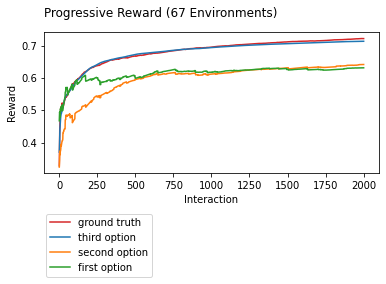

In [25]:
labels=['third option','second option','first option','ground truth']
result2.filter_fin(2000).plot_learners(l=['ope_reward','eval_type'],p='openml_task',labels=labels)

In this plot the third option looks pretty good. It almost perfectly matches the average online performance across 75 unique classification datasets. Unfortunately, this plot isn't the full story. To get this accuracy we had to sacrafice some data. Notice that the plot above only has 1,000 interactions but our original dataset had 100,000 examples.

We now create a plot that shows the all 100,000 examples so we can see how much data we threw out when using the ExplorationEvaluator.

Every openml_task not present for all ['ope_reward', 'eval_type'] has been excluded.
Interactions beyond the shortest openml_task have been excluded.


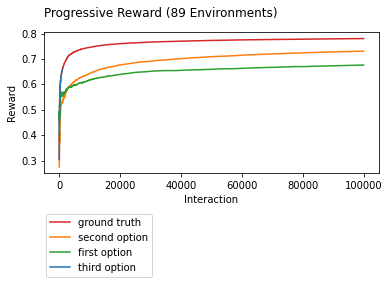

In [26]:
labels=['second option','first option','ground truth']

result2\
    .filter_val(eval_type={'!=':'ExplorationEvaluator'})\
    .plot_learners(l=['ope_reward','eval_type'],p='openml_task',labels=labels,colors=[1,2,3],out=None)

result2\
    .filter_val(eval_type={'=':'ExplorationEvaluator'})\
    .filter_fin(1000,['ope_reward','eval_type'],'openml_task')\
    .plot_learners(labels='third option',colors=0)